
**Import required libraries**

In [7]:
##Importing required libraries
import os
import time
import gc
import warnings
warnings.filterwarnings("ignore")
# data manipulation
import json
from pandas.io.json import json_normalize
import numpy as np
import pandas as pd
import pandas_profiling
# plot
import matplotlib.pyplot as plt
import seaborn as sns
color = sns.color_palette()

In [ ]:
#!pip install -U pandas-profiling

In [8]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [9]:
# Navigate to My Drive directory to store the dataset
%cd /content/drive/My Drive/Colab Notebooks/NLP_GStore/Project/

/content/drive/My Drive/Colab Notebooks/NLP_GStore/Project


In [ ]:
"""
import urllib.request
print('Beginning file download with urllib2...')
url = 'https://storage.googleapis.com/gstoretrain/train.csv'
urllib.request.urlretrieve(url, 'train.csv')
url = 'https://storage.googleapis.com/gstoretrain/test.csv'  
urllib.request.urlretrieve(url, 'test.csv')
"""

Beginning file download with urllib2...


('test.csv', <http.client.HTTPMessage at 0x7fea13584518>)

In [10]:
#Function to load the data from the folder
#Loads the data and flattens the JSON Columns such as
# Device, GeoNetwork, Totals, TrafficCource etc

%%time
def load_dataframe(csv_path='train.csv', nrows=None):
    JSON_COLUMNS = ['device', 'geoNetwork', 'totals', 'trafficSource']
    
    df = pd.read_csv(csv_path, 
                     converters={column: json.loads for column in JSON_COLUMNS}, 
                     dtype={'fullVisitorId': 'str'}, # Important!!
                     nrows=nrows)
    
    for column in JSON_COLUMNS:
        column_as_df = json_normalize(df[column])
        column_as_df.columns = [f"{column}.{subcolumn}" for subcolumn in column_as_df.columns]
        df = df.drop(column, axis=1).merge(column_as_df, right_index=True, left_index=True)
    print(f"Loaded {os.path.basename(csv_path)}. Shape: {df.shape}")
    return df

gc.collect()

CPU times: user 39.6 ms, sys: 2.06 ms, total: 41.6 ms
Wall time: 41.6 ms


In [11]:
# Dataframe contains 903.6K Rows and 55 Cols in Training
# Dataframe contains 804.7K Rows and 53 Cols in Testing
traindf = load_dataframe('https://storage.googleapis.com/gstoretrain/train.csv')
testdf = load_dataframe('https://storage.googleapis.com/gstoretrain/test.csv')

Loaded train.csv. Shape: (903653, 55)
Loaded test.csv. Shape: (804684, 53)


**Basic Data Exploration**

In [12]:
# Taking a peek at the data. Below command displays first 5 rows
traindf.head()

,channelGrouping,date,fullVisitorId,sessionId,socialEngagementType,visitId,visitNumber,visitStartTime,device.browser,device.browserVersion,device.browserSize,device.operatingSystem,device.operatingSystemVersion,device.isMobile,device.mobileDeviceBranding,device.mobileDeviceModel,device.mobileInputSelector,device.mobileDeviceInfo,device.mobileDeviceMarketingName,device.flashVersion,device.language,device.screenColors,device.screenResolution,device.deviceCategory,geoNetwork.continent,geoNetwork.subContinent,geoNetwork.country,geoNetwork.region,geoNetwork.metro,geoNetwork.city,geoNetwork.cityId,geoNetwork.networkDomain,geoNetwork.latitude,geoNetwork.longitude,geoNetwork.networkLocation,totals.visits,totals.hits,totals.pageviews,totals.bounces,totals.newVisits,totals.transactionRevenue,trafficSource.campaign,trafficSource.source,trafficSource.medium,trafficSource.keyword,trafficSource.adwordsClickInfo.criteriaParameters,trafficSource.isTrueDirect,trafficSource.referralPath,trafficSource.adwordsClickInfo.page,trafficSource.adwordsClickInfo.slot,trafficSource.adwordsClickInfo.gclId,trafficSource.adwordsClickInfo.adNetworkType,trafficSource.adwordsClickInfo.isVideoAd,trafficSource.adContent,trafficSource.campaignCode
0,Organic Search,20160902,1131660440785968503,1131660440785968503_1472830385,Not Socially Engaged,1472830385,1,1472830385,Chrome,not available in demo dataset,not available in demo dataset,Windows,not available in demo dataset,False,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,desktop,Asia,Western Asia,Turkey,Izmir,(not set),Izmir,not available in demo dataset,ttnet.com.tr,not available in demo dataset,not available in demo dataset,not available in demo dataset,1,1,1,1,1,NaN,(not set),google,organic,(not provided),not available in demo dataset,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Organic Search,20160902,377306020877927890,377306020877927890_1472880147,Not Socially Engaged,1472880147,1,1472880147,Firefox,not available in demo dataset,not available in demo dataset,Macintosh,not available in demo dataset,False,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,desktop,Oceania,Australasia,Australia,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,dodo.net.au,not available in demo dataset,not available in demo dataset,not available in demo dataset,1,1,1,1,1,NaN,(not set),google,organic,(not provided),not available in demo dataset,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Organic Search,20160902,3895546263509774583,3895546263509774583_1472865386,Not Socially Engaged,1472865386,1,1472865386,Chrome,not available in demo dataset,not available in demo dataset,Windows,not available in demo dataset,False,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,desktop,Europe,Southern Europe,Spain,Community of Madrid,(not set),Madrid,not available in demo dataset,unknown.unknown,not available in demo dataset,not available in demo dataset,not available in demo dataset,1,1,1,1,1,NaN,(not set),google,organic,(not provided),not available in demo dataset,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Organic Search,20160902,4763447161404445595,4763447161404445595_1472881213,Not Socially Engaged,1472881213,1,1472881213,UC Browser,not available in demo dataset,not available in demo dataset,Linux,not available in demo dataset,False,not ava

In [ ]:
traindf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 903653 entries, 0 to 903652
Data columns (total 55 columns):
 #   Column                                             Non-Null Count   Dtype 
---  ------                                             --------------   ----- 
 0   channelGrouping                                    903653 non-null  object
 1   date                                               903653 non-null  int64 
 2   fullVisitorId                                      903653 non-null  object
 3   sessionId                                          903653 non-null  object
 4   socialEngagementType                               903653 non-null  object
 5   visitId                                            903653 non-null  int64 
 6   visitNumber                                        903653 non-null  int64 
 7   visitStartTime                                     903653 non-null  int64 
 8   device.browser                                     903653 non-null  object
 9   devi

In [ ]:
# The library below provides a quick summary of the datatraindf.profile_report()

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
!pip install -U sweetviz

     |████████████████████████████████| 327kB 2.8MB/s 


In [ ]:
import sweetviz as sv

my_report = sv.analyze(traindf)
my_report.show_html() # Default arguments will generate to "SWEETVIZ_REPORT.html"
#Renamed this report to Initial_Analysis_Report.html
#The report contains the basic exploratory data analysis with plot distributions for individual independent variables

:FEATURES DONE:                    |█████████████████████| [100%]   01:05  -> (00:00 left)
:PAIRWISE DONE:                    |█████████████████████| [100%]   35:59  -> (00:00 left)


Creating Associations graph... DONE!
Report SWEETVIZ_REPORT.html was generated! NOTEBOOK/COLAB USERS: no browser will pop up, the report is saved in your notebook/colab files.


### Target Variable Distribution ###

In [15]:
y = np.nan_to_num(np.array([float(i) for i in traindf['totals.transactionRevenue']]))
print('The ratio of customers with transaction revenue is', str((y != 0).mean()))   

The ratio of customers with transaction revenue is 0.0127427231470487


In [14]:
plt.figure(figsize=[12, 6])
sns.distplot(y[y!=0])
plt.xlabel('transactionRevenue')
plt.show()

In [16]:
traindf["totals.transactionRevenue"] = traindf["totals.transactionRevenue"].astype('float')
target = np.log1p(traindf.groupby("fullVisitorId")["totals.transactionRevenue"].sum())
print('The ratio of customers with transaction revenue is', str((target != 0).mean()))

The ratio of customers with transaction revenue is 0.013996726255903731


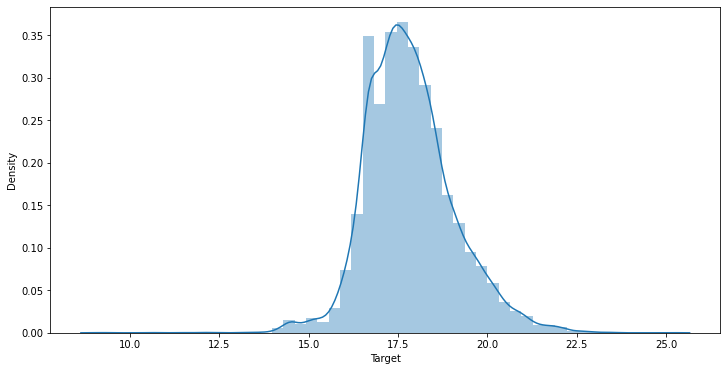

In [62]:
plt.figure(figsize=[12, 6])
sns.distplot(target[target!=0])
plt.xlabel('Target')
plt.show()

Device Group

In [18]:
def plot_categorical(data, col, size=[8 ,4], xlabel_angle=0, title='', max_cat = None):
    '''use this for ploting the count of categorical features'''
    plotdata = data[col].value_counts() / len(data)
    if max_cat != None:
        plotdata = plotdata[max_cat[0]:max_cat[1]]
    plt.figure(figsize = size)
    sns.barplot(x = plotdata.index, y=plotdata.values)
    plt.title(title)
    if xlabel_angle!=0: 
        plt.xticks(rotation=xlabel_angle)
    plt.show()
plot_categorical(data=traindf, col='device.browser', size=[8 ,4], xlabel_angle=20, title='Device - Browser', max_cat=[0, 6])

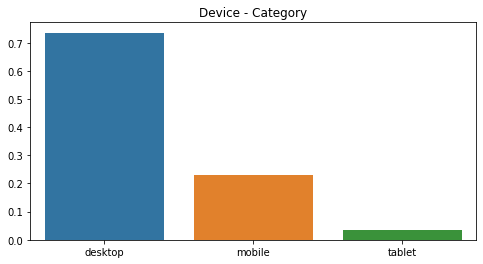

In [ ]:
plot_categorical(data=traindf, col='device.deviceCategory', size=[8 ,4], xlabel_angle=0, title='Device - Category')

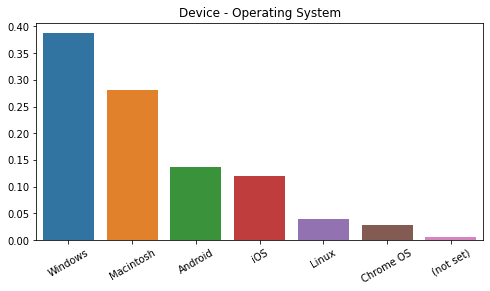

In [ ]:
plot_categorical(data=traindf, col='device.operatingSystem', size=[8 ,4], xlabel_angle=30, 
                 title='Device - Operating System', max_cat = [0, 7])

Geo Network Group

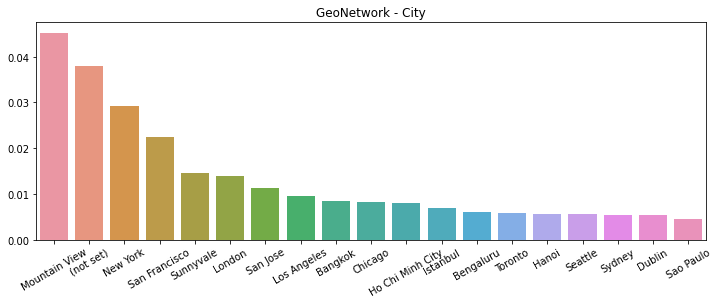

In [ ]:
plot_categorical(data=traindf, col='geoNetwork.city', size=[12 ,4], xlabel_angle=30, 
                 title='GeoNetwork - City', max_cat = [1, 20])

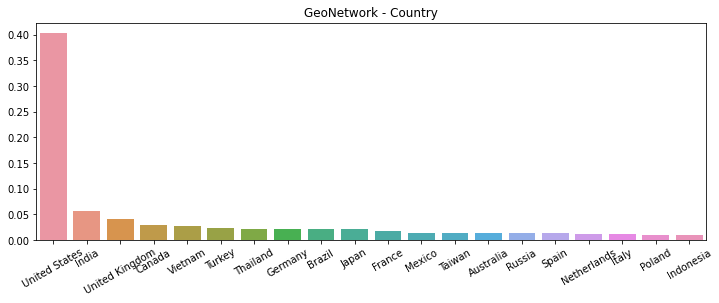

In [ ]:
plot_categorical(data=traindf, col='geoNetwork.country', size=[12 ,4], xlabel_angle=30, 
                 title='GeoNetwork - Country', max_cat = [0, 20])

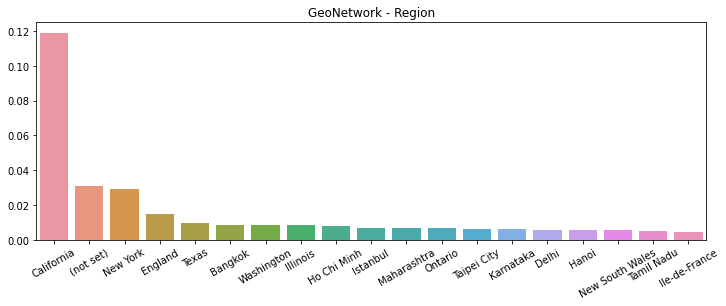

In [ ]:
plot_categorical(data=traindf, col='geoNetwork.region', size=[12 ,4], xlabel_angle=30, 
                 title='GeoNetwork - Region', max_cat = [1, 20])

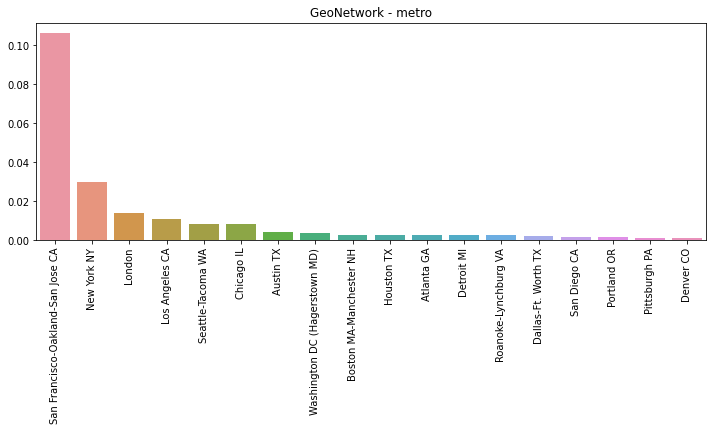

In [ ]:
plot_categorical(data=traindf, col='geoNetwork.metro', size=[12 ,4], xlabel_angle=90, 
                 title='GeoNetwork - metro', max_cat = [2, 20])

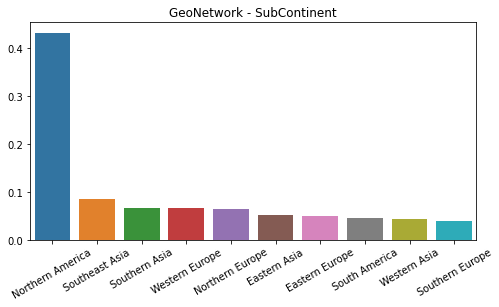

In [ ]:
plot_categorical(data=traindf, col='geoNetwork.subContinent', size=[8 ,4], xlabel_angle=30, 
                 title='GeoNetwork - SubContinent', max_cat = [0, 10])

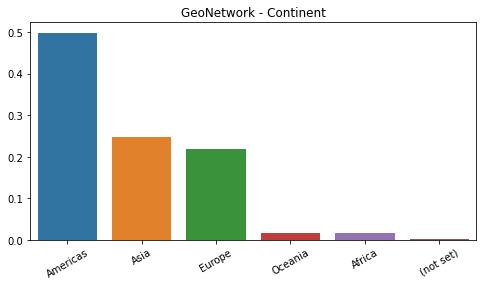

In [ ]:
plot_categorical(data=traindf, col='geoNetwork.continent', size=[8 ,4], xlabel_angle=30, 
                 title='GeoNetwork - Continent')

##Totals##

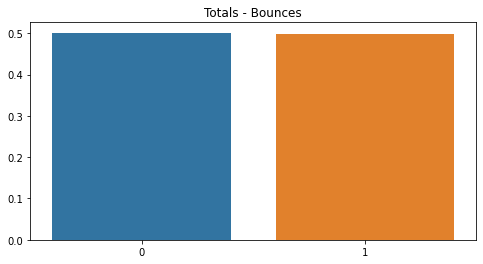

In [ ]:
traindf['totals.bounces'] = traindf['totals.bounces'].fillna('0')
plot_categorical(data=traindf, col='totals.bounces', size=[8 ,4], xlabel_angle=0, title='Totals - Bounces')

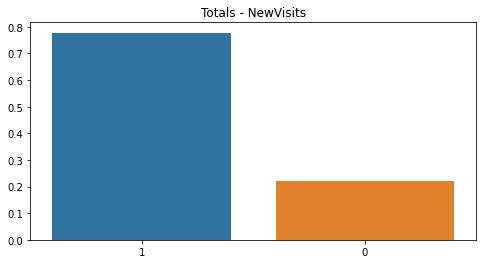

In [ ]:
traindf['totals.newVisits'] = traindf['totals.newVisits'].fillna('0')
plot_categorical(data=traindf, col='totals.newVisits', size=[8 ,4], xlabel_angle=0, title='Totals - NewVisits')

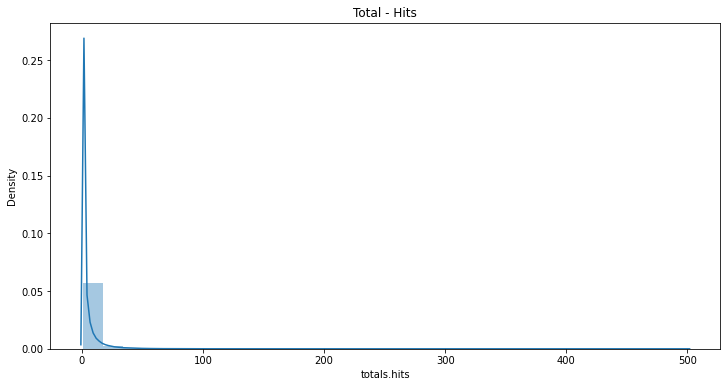

In [ ]:
plt.figure(figsize=[12, 6])
sns.distplot(traindf['totals.hits'].astype('float'), kde=True,bins=30)
plt.xlabel('totals.hits')
plt.title('Total - Hits')
plt.show()

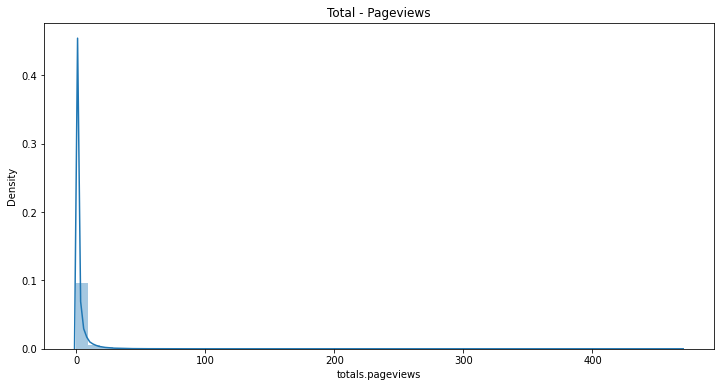

In [ ]:
plt.figure(figsize=[12, 6])
sns.distplot(traindf['totals.pageviews'].astype('float').fillna(0))
plt.xlabel('totals.pageviews')
plt.title('Total - Pageviews')
plt.show()

## Traffic Sources ##

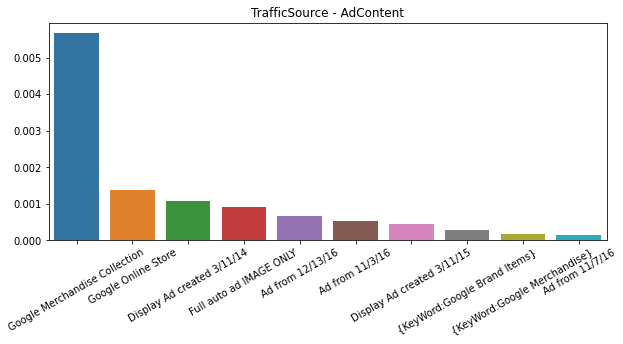

In [ ]:
plot_categorical(data=traindf, col='trafficSource.adContent', size=[10 ,4], xlabel_angle=30, 
                 title='TrafficSource - AdContent', max_cat = [0, 10])

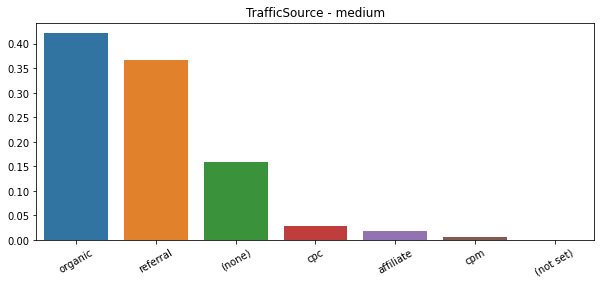

In [ ]:
plot_categorical(data=traindf, col='trafficSource.medium', size=[10 ,4], xlabel_angle=30, 
                 title='TrafficSource - medium')

### Other Groups ###

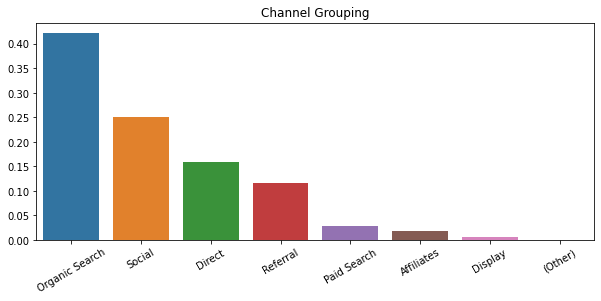

In [ ]:
plot_categorical(data=traindf, col='channelGrouping', size=[10 ,4], xlabel_angle=30, 
                 title='Channel Grouping')

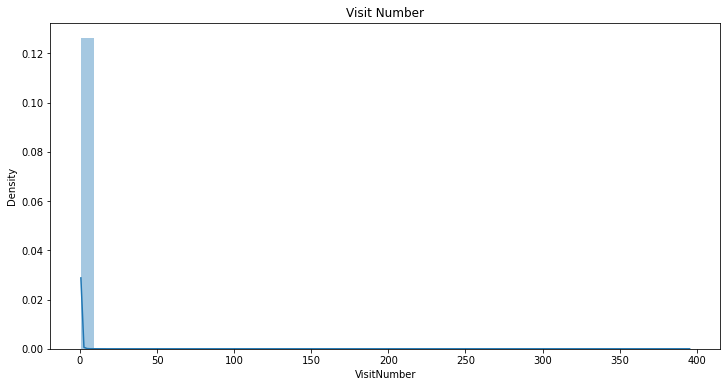

In [ ]:
a = traindf.groupby("fullVisitorId")["visitNumber"].max()
plt.figure(figsize=[12, 6])
sns.distplot(a)
plt.xlabel('VisitNumber')
plt.title('Visit Number')
plt.show()

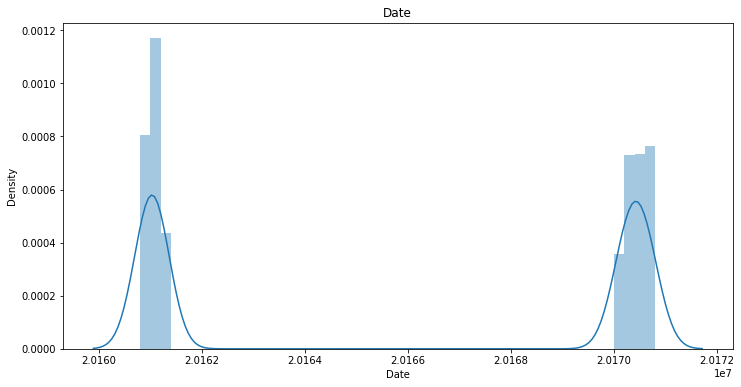

In [ ]:
plt.figure(figsize=[12, 6])
sns.distplot(traindf['date'])
plt.xlabel('Date')
plt.title('Date')
plt.show()

### Data Pre-Processing and Feature Engineering ###

### Helper Classes for Pre-processing and Feature Engineering ###

In [19]:
from sklearn.base import BaseEstimator, TransformerMixin

# Create a class to select numerical or categorical columns 
# since Scikit-Learn doesn't handle DataFrames yet
class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X[self.attribute_names].values

In [20]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import LabelEncoder

class CategoricalEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, cat_cols):
        self.cat_cols=cat_cols
        return None
    def fit(self, X, y=None):
        self.X=X
        return self
    def transform(self, X):
        X = pd.DataFrame(X)
        X.columns = self.cat_cols
        for col in self.cat_cols:
            lbl = LabelEncoder()
            lbl.fit(list(X[col].values.astype('str')))
            X[col] = lbl.transform(list(X[col].values.astype('str')))
        return X

### Feature Extraction Functions ###

In [21]:
def process_date_time(data_df):
    print("process date time ...")
    data_df['date'] = data_df['date'].astype(str)
    data_df["date"] = data_df["date"].apply(lambda x : x[:4] + "-" + x[4:6] + "-" + x[6:])
    data_df["date"] = pd.to_datetime(data_df["date"])   
    data_df["year"] = data_df['date'].dt.year
    data_df["month"] = data_df['date'].dt.month
    data_df["day"] = data_df['date'].dt.day
    data_df["weekday"] = data_df['date'].dt.weekday
    data_df['weekofyear'] = data_df['date'].dt.weekofyear
    data_df['month_unique_user_count'] = data_df.groupby('month')['fullVisitorId'].transform('nunique')
    data_df['day_unique_user_count'] = data_df.groupby('day')['fullVisitorId'].transform('nunique')
    data_df['weekday_unique_user_count'] = data_df.groupby('weekday')['fullVisitorId'].transform('nunique')
    #data_df = data_df.drop(['date','fullVisitorId'], axis=1,inplace=True)
    return data_df

def process_format(data_df):
    print("process format ...")
    for col in ['visitNumber', 'totals_hits', 'totals_pageviews']:
        data_df[col] = data_df[col].astype(float)
    data_df['trafficSource_adwordsClickInfo_isVideoAd'].fillna(True, inplace=True)
    data_df['trafficSource_isTrueDirect'].fillna(False, inplace=True)
    return data_df

def process_device(data_df):
    print("process device ...")
    data_df['browser_category']        = data_df['device_browser'] + '_' + data_df['device_deviceCategory']
    data_df['browser_operatingSystem'] = data_df['device_browser'] + '_' + data_df['device_operatingSystem']
    data_df['source_country']          = data_df['trafficSource_source'] + '_' + data_df['geoNetwork_country']
    return data_df
    
def process_totals(data_df):
    print("process totals ...")
    data_df['visitNumber']       = np.log1p(data_df['visitNumber'])
    data_df['totals_hits']       = np.log1p(data_df['totals_hits'])
    data_df['totals_pageviews']  = np.log1p(data_df['totals_pageviews'].fillna(0))
    data_df['mean_hits_per_day'] = data_df.groupby(['day'])['totals_hits'].transform('mean')
    data_df['sum_hits_per_day']  = data_df.groupby(['day'])['totals_hits'].transform('sum')
    data_df['max_hits_per_day']  = data_df.groupby(['day'])['totals_hits'].transform('max')
    data_df['min_hits_per_day']  = data_df.groupby(['day'])['totals_hits'].transform('min')
    data_df['var_hits_per_day']  = data_df.groupby(['day'])['totals_hits'].transform('var')
    return data_df

def process_geo_network(data_df):
    print("process geo network ...")
    data_df['sum_pageviews_per_network_domain']   = data_df.groupby('geoNetwork_networkDomain')['totals_pageviews'].transform('sum')
    data_df['count_pageviews_per_network_domain'] = data_df.groupby('geoNetwork_networkDomain')['totals_pageviews'].transform('count')
    data_df['mean_pageviews_per_network_domain']  = data_df.groupby('geoNetwork_networkDomain')['totals_pageviews'].transform('mean')
    data_df['sum_hits_per_network_domain']        = data_df.groupby('geoNetwork_networkDomain')['totals_hits'].transform('sum')
    data_df['count_hits_per_network_domain']      = data_df.groupby('geoNetwork_networkDomain')['totals_hits'].transform('count')
    data_df['mean_hits_per_network_domain']       = data_df.groupby('geoNetwork_networkDomain')['totals_hits'].transform('mean')
    return data_df

### Pre-processing and Feature Engineering Orchestrator Class ###

In [22]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import LabelEncoder
class AttributesPreprocessor(BaseEstimator, TransformerMixin):
    def __init__(self): # no *args or **kargs
        return None
    def fit(self, X, y=None):
        print("Fitting Data...")
        return self  # nothing else to do
    def transform(self, X, y=None):
        print("Transforming Data...")
        
        #Impute train
        X['totals_newVisits'].fillna(0,inplace=True) 
        X['totals_bounces'].fillna(0,inplace=True)
        X['trafficSource_adwordsClickInfo_page'].fillna(0,inplace=True)
        X['trafficSource_isTrueDirect'].replace({np.nan:0,'true':1},inplace=True)
        X['totals_bounces']   = X['totals_bounces'].fillna(0.0)
        X['totals_newVisits'] = X['totals_newVisits'].fillna(0.0)
        
        #Feature Engineering
        X = process_date_time(X)
        X = process_format(X)
        X = process_device(X)
        X = process_totals(X)
        X = process_geo_network(X)
        
        #Drop Columns
        cols_to_drop = [col for col in train_df.columns if train_df[col].nunique(dropna=False) == 1 and 
                        col not in ['totals_transactionRevenue','date']]
        X.drop(cols_to_drop, axis=1, inplace=True)
    
        #Column with mostly NULL value and only one NOT NULL value
        if 'trafficSource_campaign' in X.columns:
             X.drop(['trafficSource_campaign'], axis=1, inplace=True)
    
        #Drop Outlier
        #X.drop(train_df[train_df["geoNetwork_country"]=='Anguilla'].index,axis=0,inplace=True)
        
        #Drop unused columns
        ##X.drop(not_used_cols,axis=1,inplace=True)
        #print("Exit") 
        return X

### Data Preparation ###

In [23]:
train_df = traindf.copy()
train_df.columns = traindf.columns.str.replace(".","_")
train_df = train_df.sort_values('date')

#Prepare Target Variable
train_df['totals_transactionRevenue'] = train_df['totals_transactionRevenue'].astype(float)
train_df['totals_transactionRevenue'] = train_df['totals_transactionRevenue'].fillna(0)
train_df['totals_transactionRevenue'] = np.log1p(train_df['totals_transactionRevenue'])
X_train = train_df.drop('totals_transactionRevenue',axis=1)
y_train = train_df['totals_transactionRevenue']

### Invoke Orchestration Class ###  


In [24]:
X_train_copy = X_train.copy()

In [25]:
X_train = AttributesPreprocessor().fit_transform(X_train,y_train)

Fitting Data...
Transforming Data...
process date time ...
process format ...
process device ...
process totals ...
process geo network ...


### Split the Dataframe using SkLearn ###

In [26]:
from sklearn.model_selection import train_test_split
X_train_split, X_test_split, y_train_split, y_test_split = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

### Build the full pipeline ###

In [27]:
from sklearn.pipeline import Pipeline
from sklearn.pipeline import FeatureUnion
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import SimpleImputer 
num_cols = ['month_unique_user_count', 'day_unique_user_count', 'weekday_unique_user_count','visitNumber', 'totals_hits', 'totals_pageviews', 
            'mean_hits_per_day', 'sum_hits_per_day', 'min_hits_per_day', 'max_hits_per_day', 'var_hits_per_day',
            'sum_pageviews_per_network_domain', 'count_pageviews_per_network_domain', 'mean_pageviews_per_network_domain',
            'sum_hits_per_network_domain', 'count_hits_per_network_domain', 'mean_hits_per_network_domain']
cols_to_drop = [col for col in train_df.columns if train_df[col].nunique(dropna=False) == 1 and  col not in ['totals_transactionRevenue','date']]
##cat_cols     = [col for col in X_train.columns if col not in num_cols and  col not in not_used_cols and col not in cols_to_drop and col not in 'trafficSource_campaign']
cat_cols     = [col for col in X_train.columns if col not in num_cols and  col not in cols_to_drop and col not in 'trafficSource_campaign']
num_pipeline = Pipeline([
        ('selector', DataFrameSelector(num_cols)),
        #('std_scaler', StandardScaler())
        ('std_scaler', MinMaxScaler())
    ])

cat_pipeline = Pipeline([
        ('selector', DataFrameSelector(cat_cols)),
        ('cat_encoder', CategoricalEncoder(cat_cols))
    ])

full_pipeline = FeatureUnion(transformer_list=[
        ("num_pipeline", num_pipeline),
        ("cat_pipeline", cat_pipeline)
    ])

### Model Building and Cross Validation using Grid Search ###

Linear Regression

In [28]:
from sklearn.linear_model import LinearRegression
print("prepare model...")
prepare_select_and_predict_pipeline = Pipeline([
    ('preparation', full_pipeline),
    ("linRegression", LinearRegression())
])

prepare model...


In [29]:
from sklearn.model_selection import GridSearchCV
param_grid = {
    'linRegression__fit_intercept'     : [True,False],
    'linRegression__n_jobs'            : [-1]
}
grid_search_prep_LR = GridSearchCV(prepare_select_and_predict_pipeline, param_grid, cv=5,
                                scoring='neg_mean_squared_error', verbose=2, n_jobs=-1)
grid_search_prep_LR.fit(X_train_split, y_train_split)

Fitting 5 folds for each of 2 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:  7.8min finished


GridSearchCV(cv=5, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('preparation',
                                        FeatureUnion(n_jobs=None,
                                                     transformer_list=[('num_pipeline',
                                                                        Pipeline(memory=None,
                                                                                 steps=[('selector',
                                                                                         DataFrameSelector(attribute_names=['month_unique_user_count',
                                                                                                                            'day_unique_user_count',
                                                                                                                            'weekday_unique_user_count',
                                                              

Grid Search Results

In [30]:
pd.DataFrame(grid_search_prep_LR.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_linRegression__fit_intercept,param_linRegression__n_jobs,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,131.919562,4.859982,32.418556,2.606684,True,-1,"{'linRegression__fit_intercept': True, 'linReg...",-3.577546,-3.878679,-3.481699,-3.496584,-3.423469,-3.571595,0.161236,1
1,115.863767,23.217456,25.288985,7.254407,False,-1,"{'linRegression__fit_intercept': False, 'linRe...",-8.552031,-4.217642,-8.742225,-8.016377,-7.721763,-7.450008,1.656931,2


Predict using Best LR Model

In [31]:
results = pd.DataFrame(columns=["Model description", "Best Params", "Best RMSE Score", "Train RMSE","Test RMSE", "Train Time", "Test Time"])
pd.set_option('display.max_colwidth', 0)

import time
start = time.time()
grid_search_prep_LR.best_estimator_.fit(X_train_split,y_train_split)
y_train_pred = grid_search_prep_LR.best_estimator_.predict(X_train_split)
train_time = time.time() - start
start = time.time()
y_test_pred = grid_search_prep_LR.best_estimator_.predict(X_test_split)
test_time = time.time() - start

# add the result of this experiment ot the log book
results.loc[len(results)] = ["SKLearn Linear Regression Best Model",
                            grid_search_prep_LR.best_params_,
                            np.round(np.sqrt(-1 * grid_search_prep_LR.best_score_), 3),
                            np.round(np.sqrt(((y_train_split-y_train_pred)**2).mean()), 3),
                            np.round(np.sqrt(((y_test_split-y_test_pred)**2).mean()), 3),
                            train_time,
                            test_time]
results

,Model description,Best Params,Best RMSE Score,Train RMSE,Test RMSE,Train Time,Test Time
0,SKLearn Linear Regression Best Model,"{'linRegression__fit_intercept': True, 'linRegression__n_jobs': -1}",1.89,1.847,1.889,227.469388,25.512397


Grid Search Results

## XGBoost Regression

Initiatize Parameters

In [32]:
import xgboost as xgb
param = {
    'max_depth': 8,  # tried 2,4,6 & 8
    'eta': 0.01,  
    'silent': 1,  
    'objective': 'reg:linear',
    'eval_metric': 'rmse',
    'subsample': 0.6,
    'colsample_bytree': 0.8,
    'alpha':0.01,
    'num_leaves' : 40,
    'random_state': 42} 

Build Model Pipeline

In [33]:
prepare_select_and_pipeline = Pipeline([
    ('preparation', full_pipeline)])
X_train_d=prepare_select_and_pipeline.fit_transform(X_train_split)
X_test_d=prepare_select_and_pipeline.fit_transform(X_test_split)
feature_names = X_train_split.columns

Xgboost Cross Validation

Model Training using Train & Eval datasets

In [34]:
X_train_split_tr, X_train_val, y_train_split_tr, y_train_val = train_test_split(X_train_d, y_train_split, test_size=0.2, random_state=42)
X_train_tr_data = xgb.DMatrix(X_train_split_tr,label=y_train_split_tr,feature_names=feature_names)
X_val_data = xgb.DMatrix(X_train_val,label=y_train_val,feature_names=feature_names)

In [35]:
import time
start = time.time()
xgb_model = xgb.train(param, X_train_tr_data, evals=[(X_train_tr_data, 'train'), (X_val_data, 'valid')], num_boost_round=2500, early_stopping_rounds=800, verbose_eval=1000)
train_time = time.time()-start

[0]	train-rmse:2.00954	valid-rmse:2.03174
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 800 rounds.
[1000]	train-rmse:1.36244	valid-rmse:1.61998
Stopping. Best iteration:
[818]	train-rmse:1.39367	valid-rmse:1.61876



Predict Test set and Print CV Results

In [38]:
import numpy as np
X_test_data = xgb.DMatrix(X_test_d,label=y_test_split,feature_names=feature_names)
start = time.time()
preds = xgb_model.predict(X_test_data,ntree_limit=xgb_model.best_ntree_limit)
test_time=time.time()-start
preds_train = xgb_model.predict(X_train_tr_data,ntree_limit=xgb_model.best_ntree_limit)
np.round(np.sqrt(((y_test_split-preds)**2).mean()), 3)
results.loc[len(results)] = ["SKLearn Xgboost Regressor Best Model-3",
                            param,
                            np.round(xgb_model.best_score, 3),
                            np.round(np.sqrt(((y_train_split_tr-preds_train)**2).mean()), 3),
                            np.round(np.sqrt(((y_test_split-preds)**2).mean()), 3),
                            train_time,
                            test_time]

In [40]:
results

,Model description,Best Params,Best RMSE Score,Train RMSE,Test RMSE,Train Time,Test Time
0,SKLearn Linear Regression Best Model,"{'linRegression__fit_intercept': True, 'linRegression__n_jobs': -1}",1.890,1.847,1.889,227.469388,25.512397
1,SKLearn Xgboost Regressor Best Model-3,"{'max_depth': 8, 'eta': 0.01, 'silent': 1, 'objective': 'reg:linear', 'eval_metric': 'rmse', 'subsample': 0.6, 'colsample_bytree': 0.8, 'alpha': 0.01, 'num_leaves': 40, 'random_state': 42}",1.619,1.394,1.802,1910.500430,4.418982
2,SKLearn Xgboost Regressor Best Model-3,"{'max_depth': 8, 'eta': 0.01, 'silent': 1, 'objective': 'reg:linear', 'eval_metric': 'rmse', 'subsample': 0.6, 'colsample_bytree': 0.8, 'alpha': 0.01, 'num_leaves': 40, 'random_state': 42}",1.619,1.394,1.802,1910.500430,4.438262


#### LightGBM Regressor ####

In [41]:
params = {'objective' : 'regression', 
          'metric' : 'rmse', 
          'n_estimators': 10000, 
          'early_stopping_rounds': 800,
          'min_data_in_leaf' : 100,
          'num_leaves' : 150, 
          'learning_rate' : 0.01, 
          'bagging_fraction' : 0.80,
          'feature_fraction' : 0.85, 
          'bagging_seed' : 0,
          'colsample_bytree' : 0.9,
          'use_best_model': True}
    

In [42]:
prepare_select_and_pipeline = Pipeline([
    ('preparation', full_pipeline)])
X_train_d=prepare_select_and_pipeline.fit_transform(X_train_split)
X_test_d=prepare_select_and_pipeline.fit_transform(X_test_split)
#feature_names = X_train_split.columns

In [44]:
import lightgbm as lgb
X_train_split_tr, X_train_val, y_train_split_tr, y_train_val = train_test_split(X_train_d, y_train_split, test_size=0.2, random_state=42)
X_train_tr_data = lgb.Dataset(X_train_split_tr,label=y_train_split_tr,feature_name=X_train_split.columns.tolist())
X_val_data = lgb.Dataset(X_train_val,label=y_train_val,feature_name=X_train_split.columns.tolist())

In [45]:
import time
start = time.time()
lgb_model = lgb.train(params, X_train_tr_data, valid_sets=[X_val_data], num_boost_round=10000, verbose_eval=1000)
train_time = time.time()-start

Training until validation scores don't improve for 800 rounds.
[1000]	valid_0's rmse: 1.62613
Early stopping, best iteration is:
[516]	valid_0's rmse: 1.62106


In [46]:
import numpy as np
X_test_data = lgb.Dataset(X_test_d,label=y_test_split,feature_name=X_train_split.columns.tolist())
start = time.time()
preds = lgb_model.predict(X_test_d,num_iteration=lgb_model.best_iteration)
test_time=time.time()-start
preds_train = lgb_model.predict(X_train_split_tr, num_iteration=lgb_model.best_iteration)
np.round(np.sqrt(((y_test_split-preds)**2).mean()), 3)
results.loc[len(results)] = ["LightGBM Regressor Best Model-3",
                             params,
                             np.round(lgb_model.best_score['valid_0']['rmse'], 3),
                             np.round(np.sqrt(((y_train_split_tr-preds_train)**2).mean()), 3),
                             np.round(np.sqrt(((y_test_split-preds)**2).mean()), 3),
                             train_time,
                             test_time]

In [47]:
results

,Model description,Best Params,Best RMSE Score,Train RMSE,Test RMSE,Train Time,Test Time
0,SKLearn Linear Regression Best Model,"{'linRegression__fit_intercept': True, 'linRegression__n_jobs': -1}",1.890,1.847,1.889,227.469388,25.512397
1,SKLearn Xgboost Regressor Best Model-3,"{'max_depth': 8, 'eta': 0.01, 'silent': 1, 'objective': 'reg:linear', 'eval_metric': 'rmse', 'subsample': 0.6, 'colsample_bytree': 0.8, 'alpha': 0.01, 'num_leaves': 40, 'random_state': 42}",1.619,1.394,1.802,1910.500430,4.418982
2,SKLearn Xgboost Regressor Best Model-3,"{'max_depth': 8, 'eta': 0.01, 'silent': 1, 'objective': 'reg:linear', 'eval_metric': 'rmse', 'subsample': 0.6, 'colsample_bytree': 0.8, 'alpha': 0.01, 'num_leaves': 40, 'random_state': 42}",1.619,1.394,1.802,1910.500430,4.438262
3,LightGBM Regressor Best Model-3,"{'objective': 'regression', 'metric': 'rmse', 'n_estimators': 10000, 'early_stopping_rounds': 800, 'min_data_in_leaf': 100, 'num_leaves': 150, 'learning_rate': 0.01, 'bagging_fraction': 0.8, 'feature_fraction': 0.85, 'bagging_seed': 0, 'colsample_bytree': 0.9, 'use_best_model': True}",1.621,1.439,1.809,80.893394,2.983541


#### Lasso Regression ####

In [48]:
from sklearn.linear_model import Lasso
print("prepare model...")
prepare_select_and_predict_pipeline = Pipeline([
    ('preparation', full_pipeline),
    ("lassoregress", Lasso())
])

prepare model...


In [50]:
from sklearn.model_selection import GridSearchCV
param_grid = {
#    'lassoregress__fit_intercept'     : [True,False],
    'lassoregress__alpha'             : [0.001, 0.01, 0.1],
    'lassoregress__max_iter'          : [1000]
}
grid_search_prep_LS = GridSearchCV(prepare_select_and_predict_pipeline, param_grid, cv=3,
                                scoring='neg_mean_squared_error', verbose=2, n_jobs=-1)
grid_search_prep_LS.fit(X_train_split, y_train_split)

Fitting 3 folds for each of 3 candidates, totalling 9 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   7 out of   9 | elapsed: 10.3min remaining:  2.9min
[Parallel(n_jobs=-1)]: Done   9 out of   9 | elapsed: 12.2min finished


GridSearchCV(cv=3, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('preparation',
                                        FeatureUnion(n_jobs=None,
                                                     transformer_list=[('num_pipeline',
                                                                        Pipeline(memory=None,
                                                                                 steps=[('selector',
                                                                                         DataFrameSelector(attribute_names=['month_unique_user_count',
                                                                                                                            'day_unique_user_count',
                                                                                                                            'weekday_unique_user_count',
                                                              

In [51]:
pd.DataFrame(grid_search_prep_LS.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_lassoregress__alpha,param_lassoregress__max_iter,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
0,258.301807,12.610774,56.558629,1.665416,0.001,1000,"{'lassoregress__alpha': 0.001, 'lassoregress__max_iter': 1000}",-3.436067,-3.478565,-3.480194,-3.464942,0.020428,1
1,236.292772,11.678275,53.475251,2.525270,0.01,1000,"{'lassoregress__alpha': 0.01, 'lassoregress__max_iter': 1000}",-3.445911,-3.479849,-3.484387,-3.470049,0.017169,2
2,158.628842,39.534609,46.369024,15.919638,0.1,1000,"{'lassoregress__alpha': 0.1, 'lassoregress__max_iter': 1000}",-4.025966,-4.041743,-4.047191,-4.038300,0.009000,3


Lasso Model

In [52]:
import time
start = time.time()
grid_search_prep_LS.best_estimator_.fit(X_train_split,y_train_split)
y_train_pred = grid_search_prep_LS.best_estimator_.predict(X_train_split)
train_time = time.time() - start
start = time.time()
y_test_pred = grid_search_prep_LS.best_estimator_.predict(X_test_split)
test_time = time.time() - start
# add the result of this experiment ot the log book
results.loc[len(results)] = ["SKLearn Lasso Regression Best Model",
                            grid_search_prep_LS.best_params_,
                            np.round(np.sqrt(-1 * grid_search_prep_LS.best_score_), 3),
                            np.round(np.sqrt(((y_train_split-y_train_pred)**2).mean()), 3),
                            np.round(np.sqrt(((y_test_split-y_test_pred)**2).mean()), 3),
                            train_time,
                            test_time]

Ridge Model

In [53]:
from sklearn.linear_model import Ridge
print("prepare model...")
prepare_select_and_predict_pipeline = Pipeline([
    ('preparation', full_pipeline),
    ("ridgeregress", Ridge())
])

prepare model...


In [54]:
from sklearn.model_selection import GridSearchCV
param_grid = {
#    'lassoregress__fit_intercept'     : [True,False],
    'ridgeregress__alpha'             : [0.1],
    'ridgeregress__max_iter'          : [1000],
    'ridgeregress__solver'            : ['auto']
}
grid_search_prep_RR = GridSearchCV(prepare_select_and_predict_pipeline, param_grid, cv=3,
                                scoring='neg_mean_squared_error', verbose=2, n_jobs=-1)
grid_search_prep_RR.fit(X_train_split, y_train_split)

Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:  2.6min finished


GridSearchCV(cv=3, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('preparation',
                                        FeatureUnion(n_jobs=None,
                                                     transformer_list=[('num_pipeline',
                                                                        Pipeline(memory=None,
                                                                                 steps=[('selector',
                                                                                         DataFrameSelector(attribute_names=['month_unique_user_count',
                                                                                                                            'day_unique_user_count',
                                                                                                                            'weekday_unique_user_count',
                                                              

In [55]:
pd.DataFrame(grid_search_prep_RR.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_ridgeregress__alpha,param_ridgeregress__max_iter,param_ridgeregress__solver,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
0,86.602057,9.13389,36.238754,3.324815,0.1,1000,auto,"{'ridgeregress__alpha': 0.1, 'ridgeregress__max_iter': 1000, 'ridgeregress__solver': 'auto'}",-3.454257,-3.505532,-3.458525,-3.472771,0.023231,1


In [56]:
import time
start = time.time()
grid_search_prep_RR.best_estimator_.fit(X_train_split,y_train_split)
y_train_pred = grid_search_prep_RR.best_estimator_.predict(X_train_split)
train_time = time.time() - start
start = time.time()
y_test_pred = grid_search_prep_RR.best_estimator_.predict(X_test_split)
test_time = time.time() - start
# add the result of this experiment ot the log book
results.loc[len(results)] = ["SKLearn Ridge Regression Best Model-3",
                            grid_search_prep_RR.best_params_,
                            np.round(np.sqrt(-1 * grid_search_prep_RR.best_score_), 3),
                            np.round(np.sqrt(((y_train_split-y_train_pred)**2).mean()), 3),
                            np.round(np.sqrt(((y_test_split-y_test_pred)**2).mean()), 3),
                            train_time,
                            test_time]

In [90]:
results

,Model description,Best Params,Best RMSE Score,Train RMSE,Test RMSE,Train Time,Test Time
0,SKLearn Linear Regression Best Model,"{'linRegression__fit_intercept': True, 'linRegression__n_jobs': -1}",1.890,1.847,1.889,227.469388,25.512397
1,SKLearn Xgboost Regressor Best Model-3,"{'max_depth': 8, 'eta': 0.01, 'silent': 1, 'objective': 'reg:linear', 'eval_metric': 'rmse', 'subsample': 0.6, 'colsample_bytree': 0.8, 'alpha': 0.01, 'num_leaves': 40, 'random_state': 42}",1.619,1.394,1.802,1910.500430,4.418982
2,SKLearn Xgboost Regressor Best Model-3,"{'max_depth': 8, 'eta': 0.01, 'silent': 1, 'objective': 'reg:linear', 'eval_metric': 'rmse', 'subsample': 0.6, 'colsample_bytree': 0.8, 'alpha': 0.01, 'num_leaves': 40, 'random_state': 42}",1.619,1.394,1.802,1910.500430,4.438262
3,LightGBM Regressor Best Model-3,"{'objective': 'regression', 'metric': 'rmse', 'n_estimators': 10000, 'early_stopping_rounds': 800, 'min_data_in_leaf': 100, 'num_leaves': 150, 'learning_rate': 0.01, 'bagging_fraction': 0.8, 'feature_fraction': 0.85, 'bagging_seed': 0, 'colsample_bytree': 0.9, 'use_best_model': True}",1.621,1.439,1.809,80.893394,2.983541
4,SKLearn Lasso Regression Best Model,"{'lassoregress__alpha': 0.001, 'lassoregress__max_iter': 1000}",1.861,1.850,1.882,287.873404,26.312481
5,SKLearn Ridge Regression Best Model-3,"{'ridgeregress__alpha': 0.1, 'ridgeregress__max_iter': 1000, 'ridgeregress__solver': 'auto'}",1.864,1.847,1.890,224.728464,25.636091


# Feature Importance

## XGBoost Feature Importance

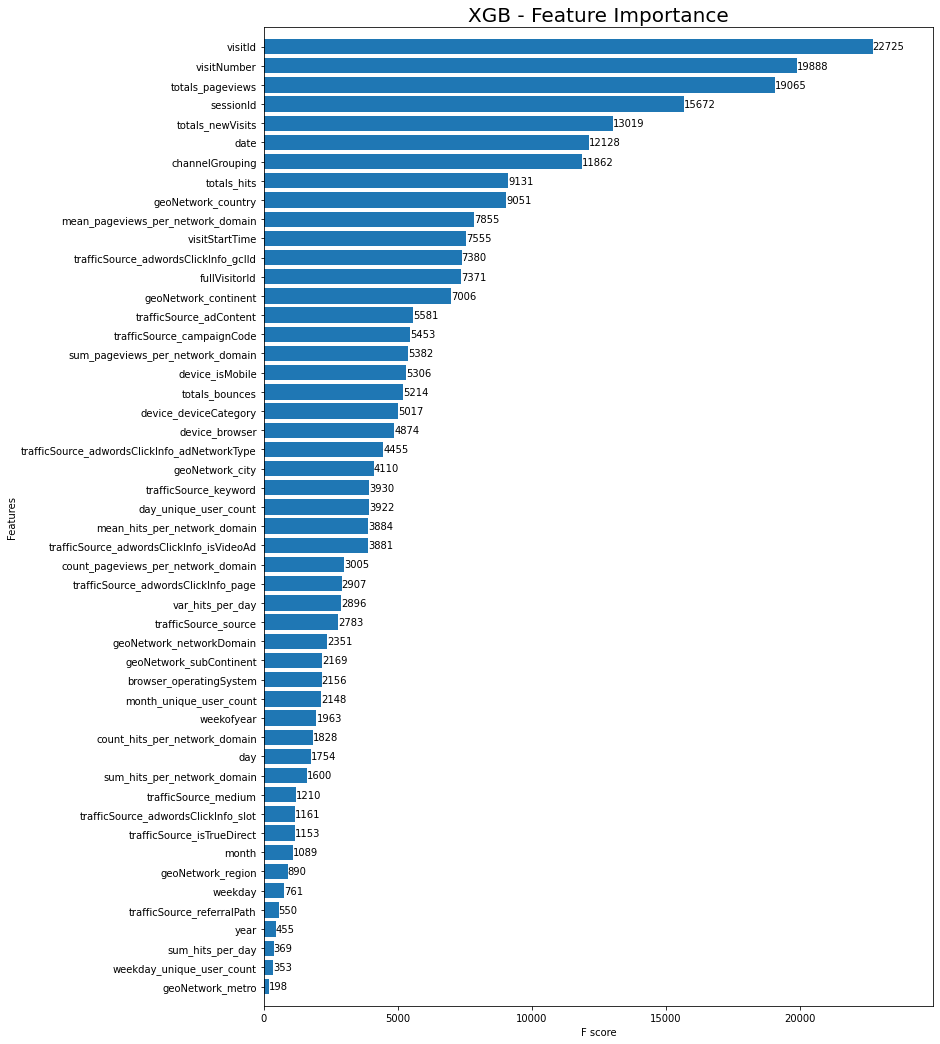

In [65]:
%matplotlib inline
from xgboost import plot_importance
fig, ax = plt.subplots(figsize=(12,18))
#X_train_data.feature_names
#xgb_model.get_fscore()
#mapper = {'f{0}'.format(i): v for i, v in enumerate(X_train_data.feature_names)}
#mapped = {mapper[k]: v for k, v in xgb_model.get_fscore().items()}
xgb.plot_importance(xgb_model,max_num_features=50, height=0.8, ax=ax)
ax.grid(False)
plt.title("XGB - Feature Importance", fontsize=20)
plt.show()

LightGBM Regressor

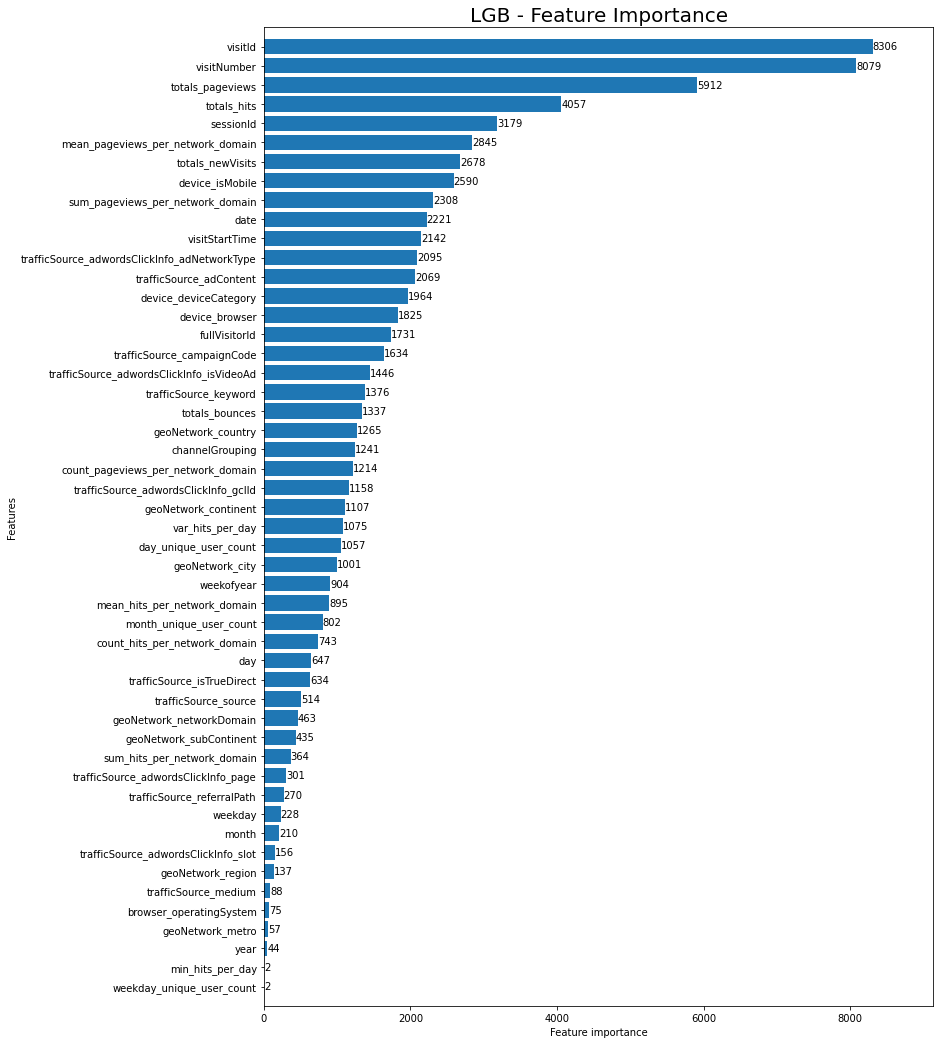

In [66]:
from lightgbm import plot_importance
fig, ax = plt.subplots(figsize=(12,18))
#X_train_data.feature_names
#xgb_model.get_fscore()
#mapper = {'f{0}'.format(i): v for i, v in enumerate(X_train_data.feature_names)}
#mapped = {mapper[k]: v for k, v in xgb_model.get_fscore().items()}
lgb.plot_importance(lgb_model,max_num_features=50, height=0.8, ax=ax)
ax.grid(False)
plt.title("LGB - Feature Importance", fontsize=20)
plt.show()

### Predictor Variables Correlation Heat Map ###

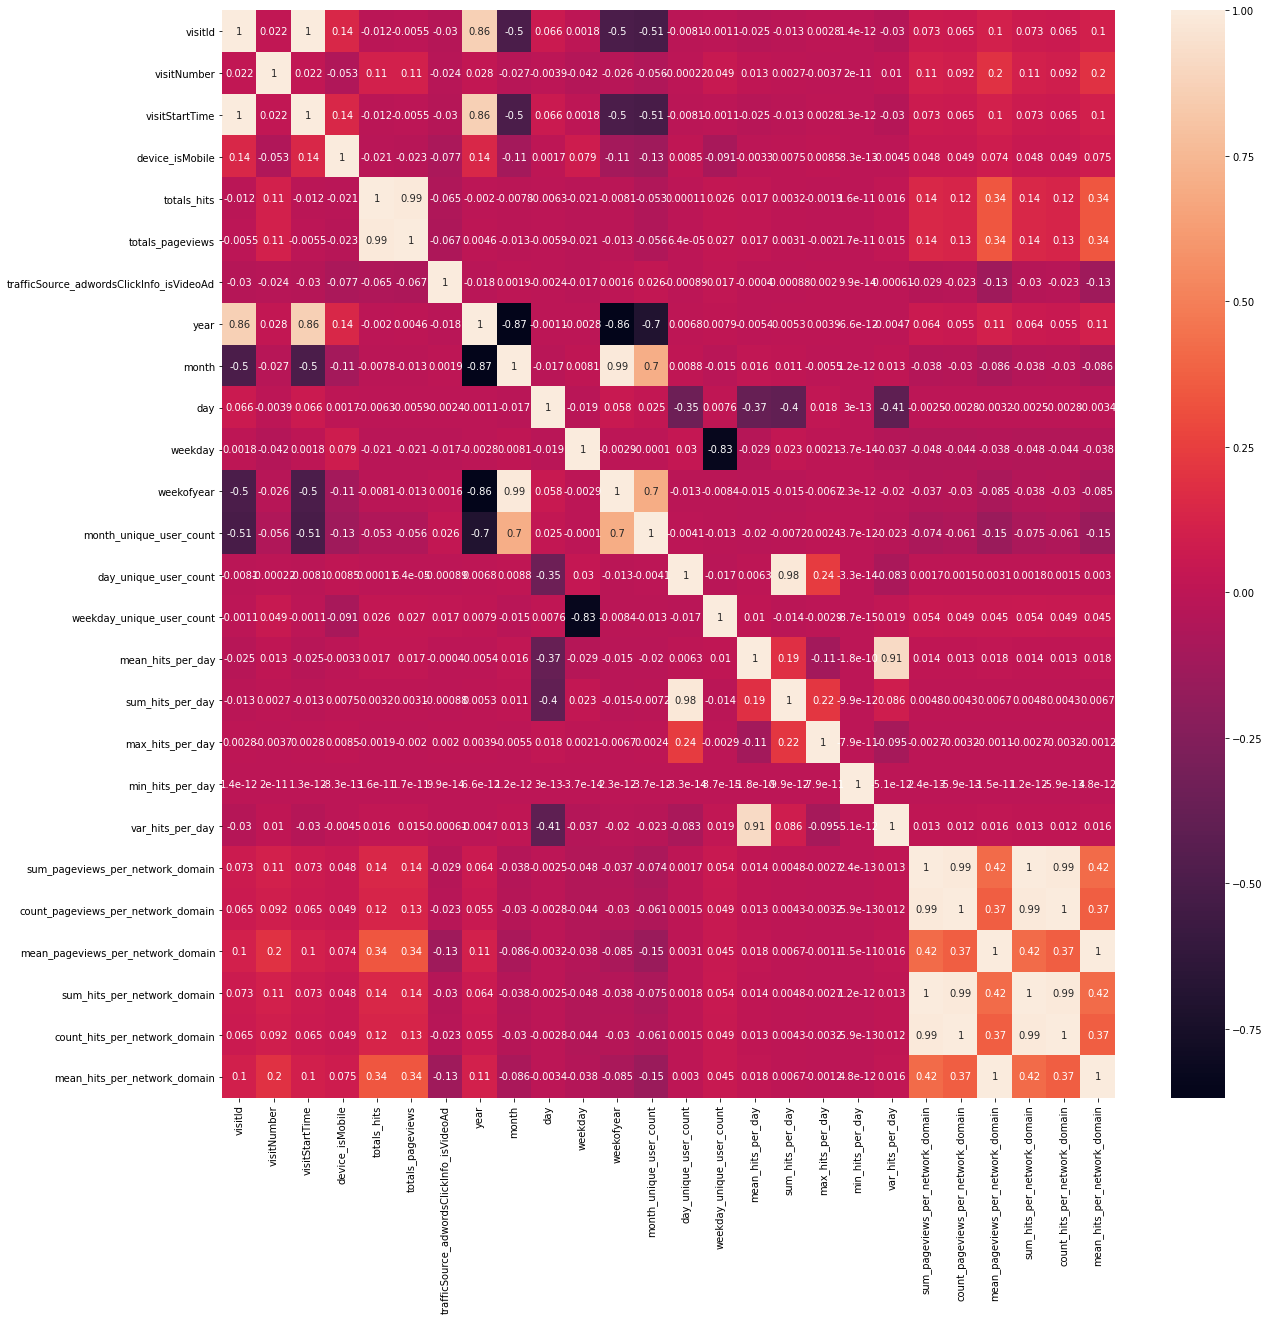

In [ ]:
plt.figure(figsize=(20,20))
sns.heatmap(X_train.corr(),annot=True)